# HOMEWORK 1: TELLURIUM AND PYTHON

In [1]:
# Preliminaries
!pip install -q tellurium
import tellurium as te
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


# Radio Immunoassays

Antibodies are proteins with very high affinities to specific molecules called antigens. Because of their specificity,
antibodies can be used to get very precise assays. One approach is radioimmunoassay (RIA).

The principle of RIA involves competitive binding of radiolabeled antigen and unlabeled antigen to a high-affinity antibody. The labeled antigen is mixed with antibody at a concentration that saturates the antigen-binding sites of the antibody. Then test samples of unlabeled antigen of unknown concentration are added in progressively larger amounts. The antibody does not distinguish labeled from unlabeled antigen, so the two kinds of antigen compete for available binding sites on the antibody. As the concentration of unlabeled antigen increases, more labeled antigen will be displaced from the binding sites. The decrease in the amount of radiolabeled antigen bound to specific antibody in the presence of the test sample is measured in order to determine the amount of antigen present in the test sample.

In this problem, you will:
1. (40 pt) Write an Antimony reaction network for the interactions between an antibody and its labelled and unlabelled antigen. Assume mass action kinetics with a kinetic constant of 1.
1. (50 pt) Our intuition is that bound, labelled antigen should *decrease* as we increase the amount of unlabelled antigen (because of competition for antibody binding sites). Write a python funtion that calculates bound, labelled antigen at steady state from given an initial value of unlabelled antigen, then construct a plot that demonstrates this effect.
1. (10 pt) Describe how a lab can use the curve you plotted in (2) to determine the concentration of antigen in a test specimen from the amount of unlabelled antigen.

To simplify matters, use mass action kinetics in which all kinetic constants are 1.

Requirements for the functions you write:
1. Document the data type and semantics of the inputs to and outputs from functions
1. The function must have a comment that describes what it does.
1. Include a test. A test must have an ``assert`` statement.

# Q1: Antimony Model

Let ``Agu`` be the unlabelled antigen and ``Agl`` be the labelled antigen. ``Ab`` is the antibody.

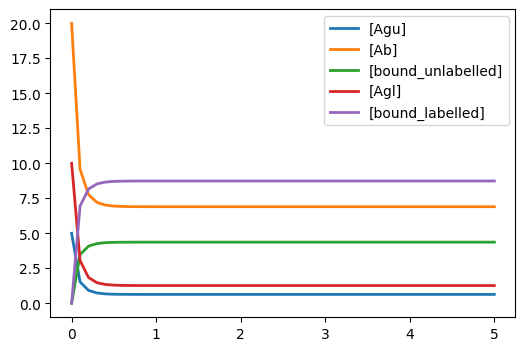

In [2]:
antibody_model = """
Agu + Ab -> bound_unlabelled; k1*Agu*Ab
Agl + Ab -> bound_labelled; k1*Agl*Ab
bound_unlabelled -> Agu + Ab; k2*bound_unlabelled
bound_labelled -> Agl + Ab; k2*bound_labelled

Agu = 5
Agl = 10
Ab = 20
bound_labelled = 0
bound_unlabelled = 0
k1 = 1
k2 = 1
"""
rr = te.loada(antibody_model)
rr.simulate()
rr.plot()

In [3]:
rr.steadyState()
rr['bound_labelled']

8.734013676289095

# Q2: Evaluation of Antimony Model

In [4]:
def findStationaryValue(roadrunner, species:str, max_time:float=1000, max_difference=0.001)->float:
    """
    Determines the time, if any, at which species changes by no more than 1 percent. Assumes that rate of change is decreasing.
    
    Args:
        roadrunner: Roadrunner object
        species: Chemical species (without '[' ']')
        max_time: seconds
    
    Returns:
        Stationary value of species
    """
    num_point = max_time*1000
    rr.reset()
    data = roadrunner.simulate(0, max_time, num_point, ['time', "[" + species + "]"])
    diff_values = np.abs(np.diff(data[:, 1]))
    idxs = np.array(diff_values < max_difference)
    idxs = np.concatenate([[False], idxs])  # adjust the array length
    return data[idxs, 1][0]

# Tests
rr = te.loada(antibody_model)
assert(np.round(findStationaryValue(rr, 'bound_labelled', max_time=100), 1) == 8.6)
print("OK!")

OK!


In [5]:
np.round(findStationaryValue(rr, 'bound_labelled', max_time=100), 1)

8.6

In [6]:
def calculateBoundLabelledAntigen(agu:np.ndarray[float])->np.ndarray[float]:
    """
    Calculate the amount of bound labelled antigen at steady state given an amount of unlabelled antigen.
    
    Args:
        agu: Unlabelled antigen
    """
    if isinstance(agu, float) or isinstance(agu, int):
        values = np.array([agu])
    else:
        values = agu
    rr = te.loada(antibody_model)
    results = []
    for value in values:
        rr['Agu'] = float(value)
        bound_labelled = findStationaryValue(rr, 'bound_labelled')
        results.append(bound_labelled)
    return np.array(results)

# Tests
#assert(np.round(calculateBoundLabelledAntigen(5), 1)[0] == 4.6)
assert(len(calculateBoundLabelledAntigen(range(2, 5)) == 3))
print("OK!")

OK!


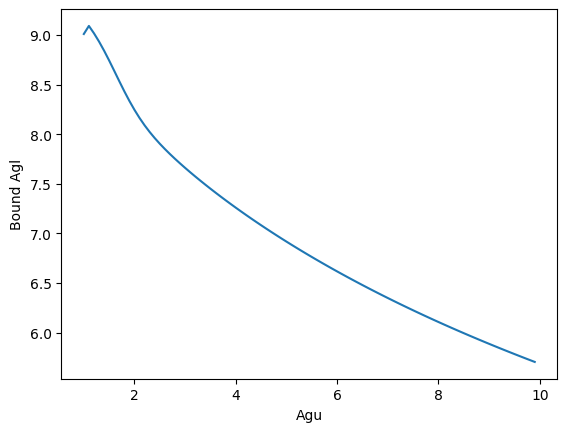

In [8]:
aguv = np.arange(1, 10, 0.1)
plt.plot(aguv, calculateBoundLabelledAntigen(aguv))
plt.xlabel('Agu')
_ = plt.ylabel('Bound Agl')

**Bug** Why the initial increase?

# Q3: Application of the analysis

We can determine the amount of unlabelled antigen by locating the amount of bound, labelled antigen in the above curve and finding the associated amount of Agu.